# Analysis of August 4th 2021 Flight

Goal: 
1. Import the data one time
2. Plot in modifiable windows
3. Do basic analysis with static mask
4. Show results in pretty plots

In [1]:
### Definining name of analysis ###
name = '2022-06-25_CREATeV_2021-08-04_Analysis_1Hz'
data_path = '../../data/'
data_folder = 'createv-2021-08-04'
file_name = 'august04_2021.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## Importing Packages and Libraries

In [2]:
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

In [3]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2021"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data
    
# data = main.get_data("Alton", "august04_2021.BIN")

## Defining Vehicle Parameters

In [4]:
# Vehicle parameters

prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.61797 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

## Manually Defining Mask (RATE?)

In [5]:
# Mask Initialization
mask = np.array([[1.570e5,1.665e5],
                [1.668e5,1.782e5],
                [1.794e5,1.904e5],
                [1.916e5,2.075e5],
                [2.087e5,2.166e5],
                [2.168e5,2.369e5],
                [2.381e5,2.486e5],
                [2.490e5,2.607e5],
                [2.619e5,2.671e5],
                [2.679e5,2.784e5],
                [2.800e5,3.444e5]])

In [6]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())                      # Bank angle in radians

# Atmospheric adjustments:
rho = df.Pressure.to_numpy() * (287 * (df.AmbientTemperature.to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df.Airspeed.to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"]
v_esc = df["EscVoltage"]

# Estimated propulsive power
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_15602/827010418.py:7: RuntimeWarning: invalid value encountered in reciprocal
  rho = df.Pressure.to_numpy() * (287 * (df.AmbientTemperature.to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_15602/827010418.py:9: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/Performance_Investigations/../../cl_finders.py:146: RuntimeWarning: divide by zero encountered in reciprocal
  J_tas = v_tas * (n * propeller.diameter)**-1             # Advance ratio at TAS
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/Performance_Investigations/../../cl_finders.py:146: RuntimeWarning: invalid value encountered in reciprocal
  J_tas = v_tas * (n * propel

In [7]:
mask[1,0]

166800.0

In [8]:
mask[1,1]

178200.0

In [9]:
df.index[int(mask[2,0]):int(mask[2,1])]

DatetimeIndex([], dtype='datetime64[ns]', name='Time', freq='S')

In [17]:
test = df.Airspeed[int(mask[1,0]):int(mask[1,1])]

In [18]:
test = df.Airspeed[int(1.570e5):int(1.665e5)]


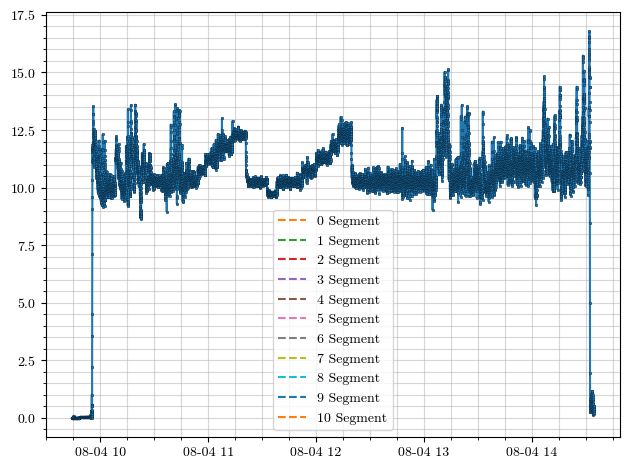

In [15]:
plt.figure()
plt.plot(df.index, v_tas)
for i in np.arange(len(mask)):
    plt.plot(df.Airspeed[int(mask[i,0]):int(mask[i,1])], marker='', linestyle='--', label=str(i) + " Segment")
plt.legend()
plt.show()

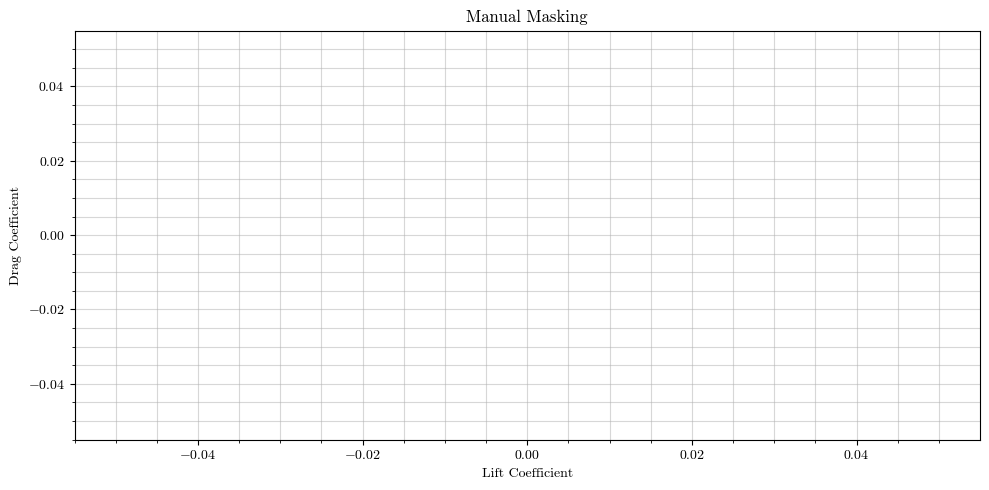

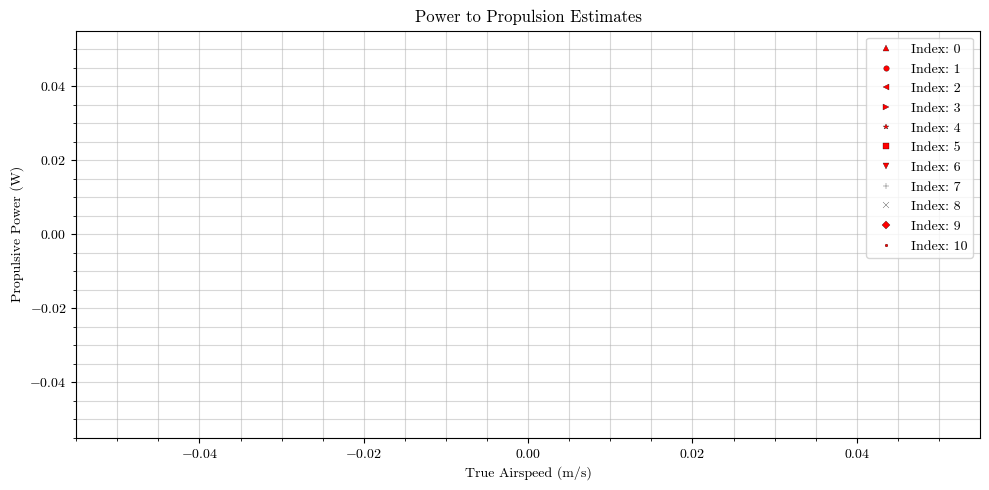

In [12]:
# Plot with static masking
plt.figure(figsize=(10,5))
plt.title("Manual Masking")

markers = ['^', 'o', '<', '>', '*', 's', 'v', '+', 'x', 'D', '.']

for i in range(len(mask)):
    plt.plot(CL[int(mask[i,0]):int(mask[i,1])], Cd_eta[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(CL[int(mask[i,0]):int(mask[i,1])], Cd_ct[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
plt.grid(True)
plt.xlabel("Lift Coefficient")
plt.ylabel("Drag Coefficient")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Power to Propulsion Estimates")
for i in range(len(mask)):
    plt.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_eta[int(mask[i,0]):int(mask[i,1])], label="Index: "+str(i), linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_ct[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
plt.grid(True)
plt.xlabel("True Airspeed (m/s)")
plt.ylabel("Propulsive Power (W)")
plt.legend()
plt.show()

In [13]:
CDct_ave = np.zeros(len(mask))
CDeta_ave = np.zeros(len(mask))
CL_ave = np.zeros(len(mask))
EAS_ave = np.zeros(len(mask))

CDct_std = np.zeros(len(mask))
CDeta_std = np.zeros(len(mask))
CL_std = np.zeros(len(mask))

for i in range(len(mask)):
    
    CDeta_ave[i] = np.mean(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_ave[i] = np.mean(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_ave[i] = np.mean(CL[int(mask[i,0]):int(mask[i,1])])
    EAS_ave[i] = np.mean(v_eas[int(mask[i,0]):int(mask[i,1])])
    
    CDeta_std[i] = np.std(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_std[i] = np.std(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_std[i] = np.std(CL[int(mask[i,0]):int(mask[i,1])])
    
# Finding drag polar:
polar_eta = cl_finders.cd2polar(createv, CDeta_ave, CL_ave)
polar_ct = cl_finders.cd2polar(createv, CDct_ave, CL_ave)

# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta, EAS = cl_finders.polar2preqew(createv, polar_eta, (7,14))
Peq_ct, EAS = cl_finders.polar2preqew(createv, polar_ct, (7,14))

/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:254: Runtime

ValueError: array must not contain infs or NaNs

NameError: name 'EAS' is not defined

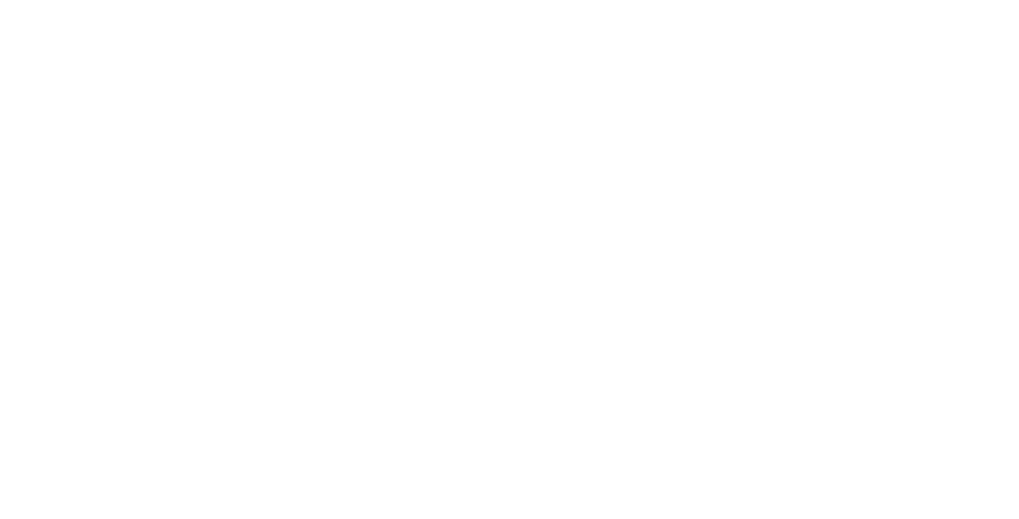

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(EAS, Peq_ct, label="Thrust Coefficient Method")
plt.plot(EAS, Peq_eta, label="Eta Coefficient Method")
plt.scatter(EAS_ave, CDct_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, marker='^', label='CT Method Points')
plt.scatter(EAS_ave, CDeta_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, marker='^', label='Eta Method Points')
plt.xlabel("Airspeed (Standard Sea-Level)")
plt.ylabel("Power Required at Standard Mass (12.6 KG)")
plt.legend()
plt.grid(True)
plt.show()
    
plt.figure(figsize=(10,5))
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_std, yerr=CL_std, fmt='+b', label="Eta Method")
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_std, yerr=CL_std, fmt='xr', label="CT Method")
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.grid(True)
plt.show()